In [59]:
!pip install xgboost
!pip install nltk
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn==1.0.2
!pip install scipy
!pip install lightgbm
!pip install hyperopt
!pip install surprise

In [60]:
import warnings
warnings.filterwarnings('ignore')

import random, re, time, xgboost, glob, os, nltk, string
import numpy as np
from numpy.linalg import svd
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
#맷플랏립 그래프 주피터에서 바로 출력하기
# from matplotlib import rc
# rc('font', family='Malgun Gothic')      #한글 폰트설정
# plt.rcParams['axes.unicode_minus']=False      #마이너스 부호 출력 설정

from scipy import stats, sparse
from scipy.stats import t, norm, chi2, chi2_contingency, skew
from sklearn.datasets import load_iris, make_classification, load_breast_cancer, load_boston, make_blobs, fetch_20newsgroups
from sklearn import datasets, tree

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Binarizer, PolynomialFeatures

from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, confusion_matrix, f1_score, classification_report,\
    precision_recall_curve, roc_auc_score, mean_squared_error, r2_score,\
    mean_absolute_error, silhouette_samples, silhouette_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, \
    GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from xgboost import plot_importance, XGBClassifier, XGBRegressor

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans

from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval

from surprise import SVD, Dataset, accuracy
from surprise.model_selection import train_test_split

from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

# 신경망의 수학적 구성요소

#### 케라스에서MNIST 데이터셋 적재하기

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
from tensorflow.keras.datasets import mnist    #손글씨 데이터셋
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [63]:
train_images.shape

(60000, 28, 28)

In [64]:
len(train_labels)

60000

In [65]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [66]:
test_images.shape

(10000, 28, 28)

In [67]:
len(test_labels)

10000

In [68]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

### 신경망 구조

**신경망 구조**

Dense 층
- 모든 입력 뉴런과 출력 뉴런 사이에 연결된 완전히 연결된(fully connected) 층을 의미 (ex. L1의 아웃풋은 L2의 인풋이 됨)
- 각 입력 뉴런과 출력 뉴런 사이의 연결 가중치를 학습하고, 입력 신호에 가중치를 곱한 후 편향(bias)을 더하는 선형 변환(linear transformation)을 수행하고 이 선형 변환의 결과에 활성화 함수(activation function)를 적용하여 출력을 계산
- 예를 들어, Dense 층은 입력 벡터 [x₁, x₂, ..., xₙ]과 가중치 행렬 W, 편향 벡터 b가 주어졌을 때, 출력 벡터 [y₁, y₂, ..., yₘ]를 계산

활성화 함수(Activation function)

- 인공 신경망에서 각 뉴런의 출력을 결정하는 비선형 함수 (ex. relu함수)
- 활성화 함수는 입력 신호의 가중치 합과 편향을 적용한 후, 그 결과에 적용되어 다음 층으로 전달
- 인공 신경망에서 비선형성을 도입하고, 신경망의 복잡한 함수 근사(approximation) 능력을 향상시키는 것
- 인공 신경망은 여러 층의 연속된 선형 변환과 비선형 활성화 함수를 조합하여 복잡한 입력과 출력 관계를 학습
- 주요 활성화 함수
  - 시그모이드(Sigmoid) 함수:
    - 범위: 0과 1 사이
    - 주요 특징: 입력값을 확률로 해석할 수 있으며, 비선형 함수로서 미분 가능
    - 단점: 큰 입력값에 대해 그래디언트 소실 문제가 발생할 수 있음
  - 하이퍼볼릭 탄젠트(Tanh) 함수:
    - 범위: -1과 1 사이
    - 주요 특징: 시그모이드와 유사하게 비선형 함수이며, 원점을 중심으로 대칭
    - 단점: 여전히 큰 입력값에 대해 그래디언트 소실 문제가 발생할 수 있음
  - 렐루(ReLU, Rectified Linear Unit) 함수:
    - 범위: 0 이상의 입력에 대해 그대로 출력, 음수 입력에 대해 0 출력
    - 주요 특징: 계산이 간단하고 빠르며, 선형 영역으로 쉽게 학습 가능
    - 단점: 음수 입력에 대해 출력이 0이 되어 해당 뉴런이 활성화되지 않는 문제가 있음 (죽은 렐루 문제)
  - 소프트맥스(Softmax) 함수:
    - 범위: 0과 1 사이
    - 주요 특징: 다중 클래스 분류에 사용되며, 출력값을 확률 분포로 해석
    - 단점: 출력값의 합이 1이 되도록 정규화되어, 다른 출력값에 영향을 받을 수 있음

In [69]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(512, activation='relu'),   # 첫 번째 인자인 512는 출력 뉴런의 수
    layers.Dense(10, activation='softmax')   # 출력을 확률로 해석하기 위해 소프트맥스 활성화 함수
])   # -> Layer1만 하고 바로 출력층으로 이어짐

### 컴파일 단계

In [70]:
model.compile(optimizer='rmsprop',   #순전파/역전파 선택
              loss='sparse_categorical_crossentropy',   #비용함수
              metrics=['accuracy'])   #평가지표

### 이미지 데이터 준비하기

In [71]:
train_images = train_images.reshape((60000,28*28))
train_images = train_images.astype('float32')/255
test_images = test_images.reshape((10000,28*28))
test_images = test_images.astype('float32')/255

In [72]:
train_images[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### 모델 훈련

In [73]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 0.2581 - accuracy: 0.9251
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1054 - accuracy: 0.9692
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0700 - accuracy: 0.9795
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0508 - accuracy: 0.9850
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0377 - accuracy: 0.9890


In [74]:
test_digits = test_images[0:10]
pred = model.predict(test_digits)

pred[0]

1/1 [==============================] - 0s 61ms/step


array([2.93901845e-08, 8.29363067e-09, 1.25496645e-05, 3.56370729e-05,
       4.48331433e-12, 3.38744965e-09, 1.06915019e-12, 9.99948978e-01,
       8.77766979e-08, 2.60412185e-06], dtype=float32)

In [75]:
test_labels[0]

7

#### -차원: 하나의 축을 따라 있는 원소의 개수(벡터 개념)
#### -랭크(nD 텐서): n개의 차원, 축의 개수

In [76]:
### 스칼라(랭크-0 텐서)
x = np.array(12)
print(x)
print(f'{x.ndim}차원')

12
0차원


In [77]:
### 스칼라(랭크-1 텐서)
x = np.array([12,3,6,14,7])
print(x)
print(f'{x.ndim}차원')

[12  3  6 14  7]
1차원


In [78]:
### 스칼라(랭크-2 텐서)
x = np.array([[12,3,6,14,7],
             [5,3,1,24,7],
             [657,2,12,8,55]])
print(x)
print(f'{x.ndim}차원')

[[ 12   3   6  14   7]
 [  5   3   1  24   7]
 [657   2  12   8  55]]
2차원


In [79]:
### 스칼라(랭크-3 텐서)
x = np.array([[[12,3,6,14,7],
             [5,3,1,24,7],
             [657,2,12,8,55]],
              [[13,88,62,1,721],
             [5,33,121,24,7],
             [6,21,112,28,5]]])
print(x,'\n')

print(x.shape)
print(f'{x.ndim}차원')

[[[ 12   3   6  14   7]
  [  5   3   1  24   7]
  [657   2  12   8  55]]

 [[ 13  88  62   1 721]
  [  5  33 121  24   7]
  [  6  21 112  28   5]]] 

(2, 3, 5)
3차원


In [80]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 핵심 속성
print(train_images.ndim)
print(train_images.shape)
print(train_images.dtype)

3
(60000, 28, 28)
uint8


In [81]:
# unit8은 8개의 비트로 256개의 서로 다른 값을 표현
# 이미지 처리에서 많이 사용되는 데이터 형식 중 하나이며, 메모리 관리가 효율적이고 연산에도 효과적
train_images.dtype

dtype('uint8')

### 5번째 이미지 출력하기

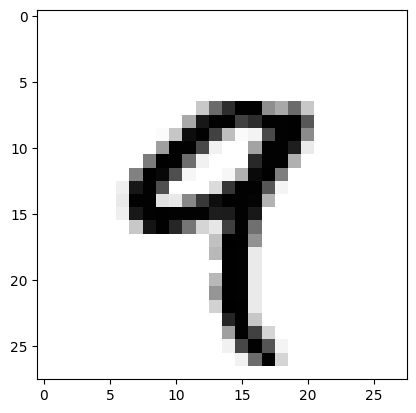

In [82]:
# MNIST 데이터셋 픽셀값은 그레이스케일 값으로 0=흰색, 255=검은색
# 보통은 0=검은색, 255=흰색 (특정 라이브러리나 플랫폼에 따라 다르게 설정할 수 있음)
digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

### 이미지 데이터
- 3차원 이미지의 차원은 "가로 픽셀 수 x 세로 픽셀 수 x 이미지 슬라이스 수"로 표현
- 픽셀은 이미지를 구성하는 가장 작은 단위로, "picture element"의 줄임말이며 이미지를 표현하는 데 사용되는 점 또는 화소
- 흑백 이미지의 경우, 각 픽셀은 단일 색상 값을 가지며, 일반적으로 0부터 255까지의 범위로 표현. 0은 픽셀이 검은색에 가깝고, 255는 픽셀이 흰색에 가깝다.
- 컬러 이미지의 경우, 각 픽셀은 일반적으로 RGB(Red, Green, Blue) 값을 가지며 각각 빨강, 초록, 파랑의 강도를 나타내며, 0부터 255까지의 범위로 표현
- 강도의 조합에 따라 다양한 색상이 생성. 예를 들어, (255, 0, 0)은 빨간색, (0, 255, 0)은 초록색, (0, 0, 255)는 파란색
- 각 픽셀은 이미지의 위치에 따라 좌표로 식별. 가장 왼쪽 위 픽셀이 (0, 0)이며, 가로 방향으로 증가하면서 픽셀의 열 인덱스가 증가하고, 세로 방향으로 증가하면서 픽셀의 행 인덱스가 증가
- 이미지 처리 작업에서는 픽셀 단위의 조작이 중요하며, 픽셀 값을 수정하거나 분석하여 다양한 이미지 효과를 생성하거나 이미지에서 정보를 추출

### 넘파이로 텐서 조작하기

In [83]:
my_slice = train_images[10:100]
my_slice.shape

(90, 28, 28)

In [84]:
my_slice = train_images[10:100, :, :]
my_slice.shape

(90, 28, 28)

In [85]:
my_slice = train_images[10:100, 0:28, 0:28]
my_slice.shape

(90, 28, 28)

In [86]:
my_slice = train_images[:, 14:, 14:]

In [87]:
# 정중앙에 위치한 14x14 픽셀 조각
my_slice = train_images[:, 7:-7, 7:-7]

### 배치 데이터

In [88]:
# 딥러닝은 관측치 하나하나가 아닌 배치 단위 묶음으로 봄
batch = train_images[:128]

In [89]:
batch = train_images[128:256]

In [90]:
n=3
batch = train_images[128*n: 128*(n+1)]

### 텐서의 실제 사례

In [91]:
# ReLU(Rectified Linear Unit) 함수를 구현
# x의 차원이 2가 아닐경우 AssertionError를 발생시킴(프로그램 실행 중 오류가 있음. 코드 실행이 중단됨)
def naive_relu(x):
  assert len(x.shape)==2    #x의 차원이 2인지 확인
  x=x.copy()

  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      x[i,j] = max(x[i,j], 0)
  return x

In [92]:
def naive_add(x,y):
  assert len(x.shape)==2
  assert x.shape == y.shape
  x=x.copy()

  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      x[i,j] += y[i,j]
  return x

In [93]:
# 넘파이 내장함수 원소별 연산 속도
x = np.random.random((20,100))
y = np.random.random((20,100))

t0 = time.time()
for _ in range(1000):
  z = x+y
  z = np.maximum(z,0)
print(f'걸린시간: {time.time()-t0:.2f}s')

걸린시간: 0.01s


In [94]:
t0 = time.time()
for _ in range(1000):
  z = naive_add(x,y)
  z = naive_relu(z)
print(f'걸린시간: {time.time()-t0:.2f}s')

걸린시간: 2.42s


### 브로드캐스팅
- 크기가 다른 두 텐서에 대한 연산
- 작은 텐서가 큰 텐서의 크기에 맞추어 확대

In [95]:
x = np.random.random((32,10))
y = np.random.random((10,))

In [96]:
y = np.expand_dims(y, axis=0)
y

array([[0.22952061, 0.38355061, 0.17388527, 0.86971119, 0.98509402,
        0.87318245, 0.54941176, 0.91636316, 0.54035659, 0.97846975]])

In [97]:
Y = np.concatenate([y]*32, axis=0)
Y[:2]

array([[0.22952061, 0.38355061, 0.17388527, 0.86971119, 0.98509402,
        0.87318245, 0.54941176, 0.91636316, 0.54035659, 0.97846975],
       [0.22952061, 0.38355061, 0.17388527, 0.86971119, 0.98509402,
        0.87318245, 0.54941176, 0.91636316, 0.54035659, 0.97846975]])

In [98]:
def naive_add_matrix_and_vector(x,y):   #행렬(2차원)과 벡터(1차원) 연산
  assert len(x.shape)==2    # x차원이 2인지 확인
  assert len(y.shape)==1    # y차원이 1인지 확인
  assert x.shape[1] == y.shape[0]    # x의 2번째 차원 길이 = y의 길이
  x = x.copy()

  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      x[i,j] += y[j]   # y값 더해서 x값 업데이트
  return x

In [99]:
# 덧셈
x = np.arange(10).reshape(2, 5)
print(x, '\n')

y = np.arange(5)
print(y, '\n')

naive_add_matrix_and_vector(x,y)

[[0 1 2 3 4]
 [5 6 7 8 9]] 

[0 1 2 3 4] 



array([[ 0,  2,  4,  6,  8],
       [ 5,  7,  9, 11, 13]])

In [100]:
x = np.random.random((64,3,32,10))
y = np.random.random((32,10))

z = np.maximum(x,y)

In [101]:
z.shape

(64, 3, 32, 10)

### 과제[1]: 텐서 곱셈(교재 79p~)

### 텐서 크기 변환

In [102]:
trian_images = train_images.reshape((60000, 28*28))

In [103]:
x = np.array([[0., 1.],
             [2., 3.],
             [4., 5.]])
x.shape

(3, 2)

In [104]:
x = x.reshape((6,1))
x

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.]])

In [105]:
x = x.reshape((2,3))
x

array([[0., 1., 2.],
       [3., 4., 5.]])

In [106]:
# 전치
x = np.zeros((300,20))
x = np.transpose(x)
x.shape

(20, 300)

### 텐서 연산의 가하학적 해석

ReLU(Recitified Linear Unit) 활성화 함수는 인공 신경망에서 널리 사용되는 활성화 함수 중 하나입니다. 이 함수는 입력값이 0보다 작을 경우 0을 출력하고, 입력값이 0보다 큰 경우 입력값을 그대로 출력합니다.

구조적과 비구조적의 차이에 대해 설명하기 전에, 구조적과 비구조적이라는 용어의 정의를 먼저 알아봅시다.

구조적(Structured) 데이터는 고정된 형식 또는 구조를 가지고 있는 데이터를 말합니다. 예를 들어, 테이블 형태의 데이터나 배열 형태의 데이터가 구조적 데이터입니다.

비구조적(Unstructured) 데이터는 고정된 형식이나 구조를 가지고 있지 않은 데이터를 말합니다. 예를 들어, 텍스트, 이미지, 오디오 등의 데이터가 비구조적 데이터입니다.

#### TensorFlow를 사용하여 변수 x에 대한 식 y = 2 * x + 3의 그래디언트(기울기)를 계산하고 tape.gradient()를 사용하여 y에 대한 x의 그래디언트를 계산. 이를 통해 x의 값을 조정할 때 y가 어떻게 변화하는지를 알 수 있으며, 이는 모델의 최적화와 역전파 알고리즘에서 매우 유용.
- TensorFlow 변수 x를 생성합니다. tf.zeros((2, 2))를 사용하여 크기가 2x2이고 모든 요소가 0인 행렬로 초기화
- tf.GradientTape()를 사용하여 GradientTape 컨텍스트를 생성하고 tape를 사용하여 연산을 기록
- y = 2 * x + 3의 연산을 수행하고 결과를 변수 y에 저장. 이 때, TensorFlow의 브로드캐스팅(broadcasting) 기능을 사용하여 x의 각 요소에 2를 곱하고 3을 더함.
- tape.gradient()를 사용하여 y에 대한 x의 그래디언트를 계산. 이를 통해 y를 x에 대해 미분한 결과, 즉 y에 대한 x의 기울기를 구한다. tape.gradient()의 첫 번째 인자로는 그래디언트를 계산하고자 하는 결과값(y)을 전달하고, 두 번째 인자로는 그래디언트를 계산하고자 하는 변수(x)를 전달.
- grad_of_y_wrt_x에는 y에 대한 x의 그래디언트가 저장된다.

### 텐서플로의 그래디언트 테이프

In [107]:
import tensorflow as tf

x = tf.Variable(tf.zeros((2,2)))
with tf.GradientTape() as tape:
    y = 2*x + 3

grad_of_y_wrt_x = tape.gradient(y, x)

In [108]:
grad_of_y_wrt_x

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>

In [109]:
w = tf.Variable(tf.random.uniform((2,2)))
b = tf.Variable(tf.zeros((2,)))
x = tf.random.uniform((2,2))

with tf.GradientTape() as tape:
  y = tf.matmul(x,w) + b
grad_of_y_wrt_w_and_b = tape.gradient(y, [w,b])

In [110]:
grad_of_y_wrt_w_and_b

[<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[1.1642376, 1.1642376],
        [0.9625721, 0.9625721]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 2.], dtype=float32)>]

#### 선형변환
- 인풋데이터 * 가중치 곱하기(행렬곱) +바이어스(편차) 추가 -> 레이어 1,2,3,4.... 를 비슷하게 바꿔줌
- 활성화 함수(relu)에 넣어 비선형변환을 해줌 -> 각각의 레이어가 같지 않게 서로 다른 역할을 해줌
- 레이어가 복잡해질수록 더 복잡한 일 처리 가능

[입력 L1 L2 L3 L4..... Ln 확률(0~m) 출력]

-> 순전파(L1 ~ Ln까지 순서대로)<br>
<- 역전파(Ln ~ L1까지 거꾸로/ 올라가며 가중치를 계속 업데이트함)

역전파를 하려면 순전파 때 했던 순서를 알아야함 : 연쇄법칙에 의해 알 수 있음<br>
f(g(h(p(q(x))))) 합성함수

#### 옵티마이저
- 최적화 방법을 찾아주는 거
- 모델의 학습 과정을 통제하고, 모델의 성능을 개선하는 역할
- 손실 함수 (또는 비용 함수)를 최소화하는 파라미터를 찾는 과정이며, 이 과정은 최적화 (Optimization)라고 함
- 옵티마이저
  - 확률적 경사 하강법 (SGD): 가장 기본적인 옵티마이저로, 각 훈련 단계에서 하나의 데이터 포인트 (또는 작은 배치)에 대한 그래디언트를 계산하여 모델 파라미터를 업데이트
    - 가중치를 반복적으로 조정하여 손실 함수를 최소화하는 최적의 모델 파라미터를 찾는 최적화 알고리즘
  - 모멘텀: 경사 하강법에 '관성' 개념을 추가하여, 최적화 과정이 수렴을 가속화하고 지역 최솟값에서 벗어나는 데 도움
  - AdaGrad: 학습률이 각 파라미터에 따라 다르게 적용되는 적응형 학습률을 사용합니다. 이는 자주 등장하지 않는 피처에 높은 학습률을 할당하는 데 도움
  - RMSProp: AdaGrad의 문제점인 학습률이 너무 빨리 감소하는 문제를 해결한 방법
  - Adam (Adaptive Moment Estimation): 모멘텀과 RMSProp의 아이디어를 결합한 옵티마이저로, 적응형 학습률과 관성 개념을 모두 사용

#### 손실 함수 (Loss Function)
- 머신러닝 모델의 예측 출력이 실제 값과 얼마나 잘 일치하는지를 측정하는 방법
- 실 함수는 모델의 성능을 수치화하며, 이를 통해 모델의 파라미터를 최적화하는 데 사용
- 유형
  - 평균 제곱 오차 (Mean Squared Error, MSE): 회귀 문제에서 가장 일반적으로 사용되는 손실 함수. 실제 값과 모델의 예측 값 사이의 차이를 제곱한 값의 평균을 계산
  - 크로스 엔트로피 (Cross-Entropy): 분류 문제에서 일반적으로 사용되는 손실 함수. 모델의 예측 확률 분포와 실제 값의 분포 사이의 차이를 측정
  - sparse_categorical_crossentropy는 크로스 엔트로피 손실 함수의 한 형태로, 다중 클래스 분류 문제에서 주로 사용
  - 힌지 손실 (Hinge Loss): 서포트 벡터 머신 (SVM)과 같은 알고리즘에서 사용
  - 로그 손실 (Log Loss): 이진 분류 문제에서 사용되며, 예측 확률을 직접적으로 반영

#### 가중치 vs 그래디언트(기울기)
가중치는 신경망의 출력을 결정하는 파라미터이며, 그래디언트는 이러한 가중치를 어떻게 조정할지를 결정하는 방향성을 제공하는 지표
- 가중치는 각 입력 특성이 출력에 미치는 영향의 정도를 나타냅니다. 가중치는 학습 과정에서 최적화되며, 초기에는 일반적으로 임의(랜덤)의 값으로 설정되고, 학습 데이터를 통해 그래디언트(기울기)를 계산하고 가중치를 업데이트함으로써 점진적으로 개선
- 그래디언트(Gradient): 그래디언트는 가중치가 변할 때 손실 함수가 어떻게 변하는지를 나타내는 지표. 그래디언트는 손실 함수의 편미분으로 계산되며, 이는 각 가중치에 대한 손실의 변화율을 나타낸다. 그래디언트는 가중치를 어떻게 업데이트할지를 결정하는데 사용되며, 손실을 줄이는 방향으로 가중치를 조정하는데 도움이 되며 그래디언트가 0인 경우, 해당 가중치는 손실에 미치는 영향이 없거나, 손실을 최소화하는 최적의 값에 도달했음을 의미

### 상수 텐서와 변수 (모두 1 또는 모두 0인 텐서)

In [111]:
import tensorflow as tf

x = tf.ones(shape=(2,1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [112]:
x = tf.zeros(shape=(2,1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


### 랜덤 텐서

In [113]:
x = tf.random.normal(shape=(3,1), mean=0, stddev=1.)   #stddev: 표준편차
print(x)

tf.Tensor(
[[-0.5176477 ]
 [-1.6437936 ]
 [ 0.57031685]], shape=(3, 1), dtype=float32)


In [114]:
# 균일분포(uniform distribution)에서 랜덤한 값들을 생성
# 딥러닝 모델을 초기화하거나 랜덤한 텐서를 생성하는데 유용하게 사용
x = tf.random.uniform(shape=(3,1), minval=0., maxval=1.)   #최소값 0, 최대값 1
print(x)

tf.Tensor(
[[0.6843357 ]
 [0.08780766]
 [0.72872925]], shape=(3, 1), dtype=float32)


### 넘파이 배열에 값 할당하기

In [115]:
import numpy as np
x = np.ones(shape=(2,2))
x[0,0] = 0.
print(x)


[[0. 1.]
 [1. 1.]]


In [116]:
# 텐서플로우 텐서에 값을 할당하지 못함 (텐서 자체로 하나의 상수 취급)
# -> 변수를 만들려면 랜덤텐서와 같이 초깃값을 제공해야 함
x = tf.ones(shape=(2,2))
x[0,0] = 0.

TypeError: ignored

### 텐서플로 변수에 값 할당하기

In [117]:
# tf.Variable은 수정 가능한 상태를 관리하기 위한 클래스
v = tf.Variable(initial_value = tf.random.normal(shape=(3,1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.2764212 ],
       [ 0.85821664],
       [-1.1116049 ]], dtype=float32)>


In [118]:
v.assign(tf.ones((3,1)))   #assign으로 값 할당할 수 있음

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

In [119]:
v[0,0].assign(3.)   #전체 텐서를 바꾸는게 아닌, 일부만 변경도 가능
print(v)   # assign은 원본을 바꿈(v= 해주지 않아도 됨)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>


### assign_add() 사용하기
- +=과 동일
- assign_sub()는 -=과 동일

In [120]:
v.assign_add(tf.ones((3,1)))   #복합대입 연산자 +=과 동일
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>


### 텐서 연산: 텐서플로에서 수학 계산하기

In [121]:
### 기본적인 수학 연산
a = tf.ones((2,2))
b = tf.square(a)   #제곱
c = tf.sqrt(a)  #제곱근(루트)
d = b+c
e = tf.matmul(a,b)   #행렬곱

In [122]:
print(a,'\n')
print(b,'\n')
print(c,'\n')
print(d,'\n')
print(e,'\n')
e *= d
print(e)

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32) 

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32) 

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32) 

tf.Tensor(
[[2. 2.]
 [2. 2.]], shape=(2, 2), dtype=float32) 

tf.Tensor(
[[2. 2.]
 [2. 2.]], shape=(2, 2), dtype=float32) 

tf.Tensor(
[[4. 4.]
 [4. 4.]], shape=(2, 2), dtype=float32)


### GradientTape API 다시 살펴보기

#### GradientTape 사용하기
- GradientTape는 텐서플로우의 핵심기능 중 하나로, 자동 미분을 수행하기 위해 사용되는 도구입니다.
- 텐서플로우는 그래디언트(gradient)를 계산하는 데에 GradientTape를 활용하여 연산 과정을 기록

In [123]:
# TensorFlow를 사용하여 변수 input_var의 제곱에 대한 그래디언트(기울기)를 계산
# result는 input_var의 제곱이므로, 이 미분값은 2*input_var가 됩니다.
# input_var의 초기값이 3 이므로, gradient(기울기)는 6

In [124]:
input_var = tf.Variable(initial_value=3.)   #텐서플로우 변수 생성

# tf.GradientTape()를 사용해 GraientTape 컨텍스트 매니저를 생성
# tape를 사용하여 연산을 기록 (result = input_var의 제곱)
with tf.GradientTape() as tape:
  result = tf.square(input_var)

# tape.gradient로 result(input_var의 제곱)를 미분해줌 = 2*input_var
gradient = tape.gradient(result, input_var)

In [125]:
gradient

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

### 상수 입력 텐서와 함께 GraientTape 사용하기

In [126]:
# 그래디언트를 계산하려면 미분 대상이 되는 텐서가 관찰 대상으로 지정되어야 하는데,
# TensorFlow 변수는 기본적으로 자동으로 관찰 대상이 됩니다
# 그러나 상수나 일반 텐서는 그렇지 않기 때문에, 이들에 대해 그래디언트를 계산하려면
# 먼저 tape.watch()함수를 사용하여 그 텐서를 관찰 대상으로 지정해야 함

In [127]:
input_const = tf.constant(3.)   #텐서플로우 상수 텐서 생성

with tf.GradientTape() as tape:
   tape.watch(input_const)   # 관찰 대상으로 지정
   result = tf.square(input_const)   # result = input_const의 제곱

gradient = tape.gradient(result, input_const)  # 미분 (result에 대한 input_const의 기울기)
# 여기서 미분하는 것은 상수가 아니라 상수값을 가진 텐서에 대한 함수임
# gradient = result의 미분= 2*input_const

In [128]:
gradient

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

#### 물리학에서 위치, 속도, 그리고 가속도는 서로 미분과 적분을 통해 연결
- 위치(position)는 시간에 대해 미분하면 속도(velocity)가 된다. 이는 위치가 시간에 따라 어떻게 변하는지를 나타내며, 이 변화율이 바로 속도이다. 즉, 위치의 그레디언트(미분값)는 속도이다.
- 속도를 시간에 대해 미분하면 가속도(acceleration)가 된다. 속도가 시간에 따라 어떻게 변하는지를 나타내며, 이 변화율이 바로 가속도이다. 즉, 속도의 그레디언트(미분값)는 가속도이다.
- 따라서, 위치의 두 번째 시간에 대한 미분값(이계도 그레디언트)은 가속도가 된다.
  - 위치를 시간에 대해 미분하면 속도
  - 속도를 시간에 대해 미분하면 가속도
  - 즉, 위치를 시간에 대해 2번 미분하면 가속도

#### 그레이디언트 테이프를 중첩하여 이계도 그레이디언트를 계산하기
- TensorFlow를 사용하여 시간(time)에 따른 위치(position)와 속도(speed)의 변화를 모델링하고, 그에 대한 가속도(acceleration)를 계산하는 예시
- 첫 번째 줄에서는 TensorFlow 변수 time을 생성하고, 초기값을 0.0으로 설정.
- 두 번째 줄에서는 tf.GradientTape()를 사용하여 outer_tape라는 GradientTape 컨텍스트를 생성합니다. outer_tape를 사용하여 가속도에 대한 그래디언트를 계산.
- 세 번째 줄에서는 inner_tape라는 또 다른 GradientTape 컨텍스트를 생성합니다. inner_tape를 사용하여 위치에 대한 그래디언트를 계산.
- 네 번째 줄에서는 position 변수에 4.9 * time ** 2의 연산 결과를 할당합니다. 이 때, 이 연산은 inner_tape 컨텍스트 내에서 기록.
- 다섯 번째 줄에서는 inner_tape.gradient()를 사용하여 position에 대한 time의 그래디언트를 계산합니다. 이를 통해 위치에 대한 시간의 변화율, 즉 속도를 구한다.
- 여섯 번째 줄에서는 outer_tape.gradient()를 사용하여 speed에 대한 time의 그래디언트를 계산합니다. 이를 통해 속도에 대한 시간의 변화율, 즉 가속도를 구한다.

따라서 acceleration에는 time에 대한 speed의 그래디언트가 저장된다.
결과적으로, 이 코드는 시간에 따른 위치를 모델링하고, 이를 기반으로 속도와 가속도를 계산한다. time 변수의 값이 변할 때 위치, 속도 및 가속도의 변화율을 계산하여 모델을 업데이트할 수 있다.

In [129]:
### 그레이디언트 테이프를 중첩하여 이계도 그레이디언트를 계산

time = tf.Variable(0.)   # 텐서플로우 변수 생성

with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
      position = 4.9 * time **2   # position = 4.9 * time제곱
  speed = inner_tape.gradient(position, time)   # speed는 position의 미분(2 * 4.9 * time)
acceleration = outer_tape.gradient(speed, time)   # acceleration는 speed의 미분(2 * 4.9 * 1)

acceleration

<tf.Tensor: shape=(), dtype=float32, numpy=9.8>

### 엔드-투-엔드 예제: 텐서플로 선형 분류기

- 2D 평면에 두 클래스의 랜덤한 포인트 생성하기

In [130]:
sample_size = 1000

a = np.random.multivariate_normal(
    mean = [0, 3],
    cov = [[1, 0.5], [0.5, 1]],
    size = sample_size
)
b = np.random.multivariate_normal(
    mean = [3, 0],
    cov = [[1, 0.5], [0.5, 1]],
    size = sample_size
)
# 2개의 포인트 셋을 만듦

In [131]:
inputs = np.vstack((a,b)).astype(np.float32)   # 하나로 합침
inputs.shape

(2000, 2)

In [132]:
targets =  np.vstack((np.zeros((sample_size, 1), dtype='float32'),
                     np.ones((sample_size, 1), dtype='float32')))
targets.shape   #타깃값 생성

(2000, 1)

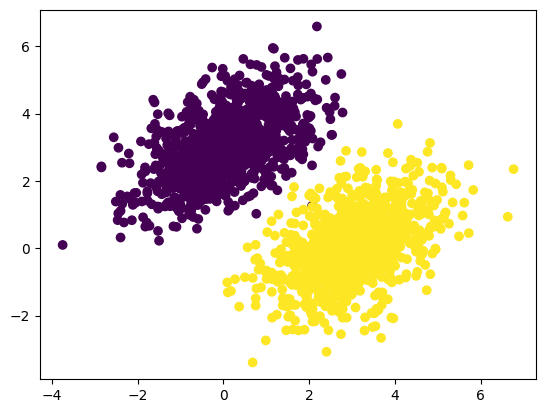

In [133]:
plt.scatter(inputs[:,0], inputs[:,1], c=targets[:,0])
plt.show()

- 선형 분류기의 변수 만들기

In [134]:
input_dim = 2    # 입력은 2D(차원) 포인트
output_dim = 1    # 출력예측은 샘플당 하나의 점수(0에 가까우면 샘플을 0클래스로 예측하고 1에 가까우면 1클래스로 예측)

W = tf.Variable(initial_value = tf.random.uniform(shape=(input_dim, output_dim)))   #가중치 행렬 변수 W 초기화
b = tf.Variable(initial_value = tf.zeros(shape=(output_dim,)))

- 정방향 패스 함수

In [135]:
def model(inputs):
  return tf.matmul(inputs, W)+b    # W=가중치, b=편향

- 평균 제곱 오차 손실 함수

In [136]:
def square_loss(targets, predictions):
  per_sample_losses = tf.square(targets - predictions)
  return tf.reduce_mean(per_sample_losses)

#### 훈련 스텝 함수

In [137]:
learning_rate = 0.1

def training_step(inputs, targets):
  with tf.GradientTape() as tape:
    predictions = model(inputs)
    loss = square_loss(targets, predictions)

  grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W,b])
  W.assign_sub(grad_loss_wrt_W * learning_rate)
  b.assign_sub(grad_loss_wrt_b * learning_rate)
  return loss

#### 배치 훈련 루프

In [138]:
for i in range(40):
  loss = training_step(inputs, targets)
  print(f'{i}번째 스텝의 손실: {loss:.4f}\n')

0번째 스텝의 손실: 5.2450

1번째 스텝의 손실: 1.0429

2번째 스텝의 손실: 0.3034

3번째 스텝의 손실: 0.1636

4번째 스텝의 손실: 0.1315

5번째 스텝의 손실: 0.1190

6번째 스텝의 손실: 0.1107

7번째 스텝의 손실: 0.1036

8번째 스텝의 손실: 0.0971

9번째 스텝의 손실: 0.0912

10번째 스텝의 손실: 0.0859

11번째 스텝의 손실: 0.0809

12번째 스텝의 손실: 0.0764

13번째 스텝의 손실: 0.0722

14번째 스텝의 손실: 0.0684

15번째 스텝의 손실: 0.0649

16번째 스텝의 손실: 0.0617

17번째 스텝의 손실: 0.0588

18번째 스텝의 손실: 0.0561

19번째 스텝의 손실: 0.0536

20번째 스텝의 손실: 0.0513

21번째 스텝의 손실: 0.0492

22번째 스텝의 손실: 0.0473

23번째 스텝의 손실: 0.0456

24번째 스텝의 손실: 0.0440

25번째 스텝의 손실: 0.0425

26번째 스텝의 손실: 0.0411

27번째 스텝의 손실: 0.0399

28번째 스텝의 손실: 0.0388

29번째 스텝의 손실: 0.0377

30번째 스텝의 손실: 0.0368

31번째 스텝의 손실: 0.0359

32번째 스텝의 손실: 0.0351

33번째 스텝의 손실: 0.0344

34번째 스텝의 손실: 0.0337

35번째 스텝의 손실: 0.0331

36번째 스텝의 손실: 0.0325

37번째 스텝의 손실: 0.0320

38번째 스텝의 손실: 0.0315

39번째 스텝의 손실: 0.0311



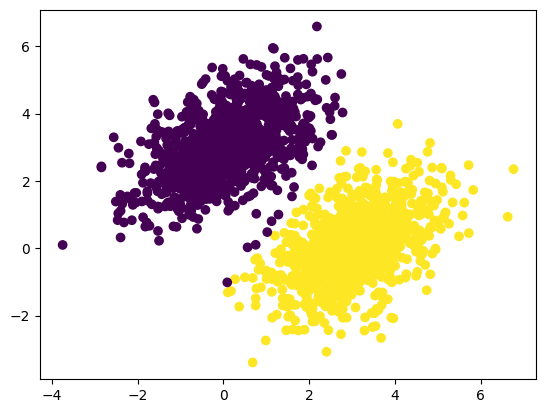

In [139]:
predictions = model(inputs)
plt.scatter(inputs[:,0], inputs[:,1], c=predictions[:,0]>0.5)
# 불린 배열은 색상 맵(color map)을 사용하여 색상으로 변환되며
# 결과적으로 이는 모델의 예측값이 0.5보다 작으면 0으로, 크면 1로 분류됨